Select 5 images with people, single or multiple, and create classifiers to detect the following features:  
- Face  
- Eyes  
- Hands  
- Nose  


## Libraries imports

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL.Image import open as open_image
from urllib.request import urlopen
import urllib

## Custom Functions

### Load images from imgur

In [5]:
# Dictionary with file name and it respective url
file_urls = {
    'lena.png':       'https://i.imgur.com/ncE3dty.png',
    'ednaldo.jpg':    'https://i.imgur.com/JnJD9FB.jpg',
#   'batman.jpg':     'https://i.imgur.com/8jKnbg5.jpg',
#   'calculista.jpg': 'https://i.imgur.com/MQNty8H.jpg',
    'vacilao.jpg':    'https://i.imgur.com/cgp0aY9.jpg',
    'harold.jpg':     'https://i.imgur.com/C8YrIjB.jpg',
    'tool.jpg':       'https://i.imgur.com/bgyZxWt.jpg'
}

# Function to load pictures from a dict of urls
load_image = lambda x : np.array(open_image(urlopen(file_urls[x])))

### Verbose function

In [3]:
# Print results from feature detection
def _verbose(image_array, feature_name=None):
    
    if isinstance(image_array, np.ndarray): # array not empty
        print(f'Found {image_array.shape[0]} {feature_name}.')
    else:
        print(f'No {feature_name[:-3]} detected.') 

### Feature detection

In [4]:
# Dected feature for a given classifier
def feature_detection(rgb_image, gray_image, classifier, 
                      scaleFactor=1.3, minNeighbors=5, reduce_penalty=False,
                      color=(255,0,0), c_name=None, 
                      return_roi=False, verbose=True):
    
    # Create empty tuples for roi
    roi_rgb, roi_gray = (), ()
    
    # Select region of interest
    classifier_results = classifier.detectMultiScale(gray_image, scaleFactor, minNeighbors)
    
    # Reduce neighbors penalty if no region found
    if len(classifier_results)==0 and reduce_penalty:
        print(f'Couldn\'t detect {c_name}, reducing minNeighbors = 1')
        classifier_results = classifier.detectMultiScale(gray_image, scaleFactor, minNeighbors=1)
    
    # Print results
    if verbose: _verbose(classifier_results, c_name)
        
    # Draw rectangle for current feature
    for (cx, cy, cw, ch) in classifier_results:
        
        # Apply drawing in image
        cv2.rectangle(img=rgb_image,       # image to draw
                      pt1=(cx, cy),        # top-left corner
                      pt2=(cx+cw, cy+ch),  # bottom-right corner
                      color=color,         # color of the rectangle (red)
                      thickness=2)         # thickness of the rectangle
    
        # Select the region of interest, both for gray and rgb scale
        if return_roi:
            roi_rgb  += ( rgb_image[cy:cy+ch, cx:cx+cw],)
            roi_gray += (gray_image[cy:cy+ch, cx:cx+cw],)
            

    # Return roi values
    if return_roi:
        return roi_rgb, roi_gray

### Search for features in images

In [12]:
# Search through an image for features
def search_for_features(image, image_name=None, reduce_penalty=False, plot_image=True, verbose=True):
    
    # Create a copy for the colored image
    rgb_image = image.copy()

    # Create gray scale image
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # Detect faces
    roi_face_rgb, roi_face_gray = feature_detection(rgb_image, gray_image, classifier=frontal_face_classifier, 
                                                    c_name='face(s)',return_roi=True, 
                                                    reduce_penalty=reduce_penalty, verbose=verbose)

    for roi_rgb, roi_gray in zip(roi_face_rgb, roi_face_gray):
        # Detect eyes
        feature_detection(roi_rgb, roi_gray, 
                          classifier=eye_classifier, color=(0,0,255), c_name='eye(s)',
                          reduce_penalty=reduce_penalty, verbose=verbose)
        # Detect smile
        feature_detection(roi_rgb, roi_gray, 
                          classifier=smile_classifier, color=(0,255,0), c_name='smile(s)',
                          reduce_penalty=reduce_penalty, verbose=verbose)
    # Detect hands
    feature_detection(rgb_image, gray_image, 
                      classifier=hand_classifier, color=(255,255,0), c_name='hand(s)',
                      reduce_penalty=reduce_penalty, verbose=verbose)
    # Plot image
    if plot_image:
        plt.figure(figsize=(12,8))
        plt.title(f'{image_name} features', size=18, pad=20, loc='left')
        plt.imshow(rgb_image)
        plt.show();

### Search for features in video

In [16]:
# Search through an image for features
def features_scan(frame, feature_penalty, reduce_penalty=False, image_name=None, verbose=True):

    # Create gray scale image
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect frontal faces
    roi_face_rgb, roi_face_gray = feature_detection(frame, gray_frame, classifier=frontal_face_classifier,
                                                    minNeighbors=feature_penalty['face'],
                                                    c_name='face(s)',return_roi=True, 
                                                    reduce_penalty=reduce_penalty, verbose=verbose)

    for roi_rgb, roi_gray in zip(roi_face_rgb, roi_face_gray):
        # Detect eyes
        feature_detection(roi_rgb, roi_gray, 
                          classifier=eye_classifier, minNeighbors=feature_penalty['eye'],
                          color=(0,0,255), c_name='eye(s)',
                          reduce_penalty=reduce_penalty, verbose=verbose)
        # Detect smile
        feature_detection(roi_rgb, roi_gray, 
                          classifier=smile_classifier, minNeighbors=feature_penalty['smile'],
                          color=(0,255,0), c_name='smile(s)',
                          reduce_penalty=reduce_penalty, verbose=verbose)
    
    # Detect profile faces
    feature_detection(frame, gray_frame, minNeighbors=feature_penalty['profile_face'],
                      classifier=profile_face_classifier, color=(255,0,255), c_name='profile face(s)',
                      verbose=verbose)
    # Detect upperbody
    #feature_detection(frame, gray_frame, minNeighbors=feature_penalty['upper_body'],
    #                  classifier=upperbody_classifier, color=(255,0,255), c_name='upper_body(s)',
    #                  verbose=verbose)
    
    # Detect hands
    feature_detection(frame, gray_frame, minNeighbors=feature_penalty['hand'],
                      classifier=hand_classifier, color=(255,255,0), c_name='hand(s)',
                      verbose=verbose)

## Load classifiers and images

In [6]:
# Load Face classifier
frontal_face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load Eye classifier
eye_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_eye.xml')

# Load Smile classifier
smile_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_smile.xml')

# Load Upper Body classifier
upperbody_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_upperbody.xml')

# Load Profile Face classifier
profile_face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_profileface.xml')

# Load Hand classifier
aGest_url = 'https://raw.githubusercontent.com/Aravindlivewire/Opencv/master/haarcascade/aGest.xml'
urllib.request.urlretrieve(aGest_url, filename='data/aGest.xml')
hand_classifier = cv2.CascadeClassifier('data/aGest.xml')

# Load images
images = {file:load_image(file) for file in file_urls.keys()}

## Features search in static images

Found 1 face(s).
Found 2 eye(s).
Found 2 smile(s).
Couldn't detect hand(s), reducing minNeighbors = 1
No hand detected.


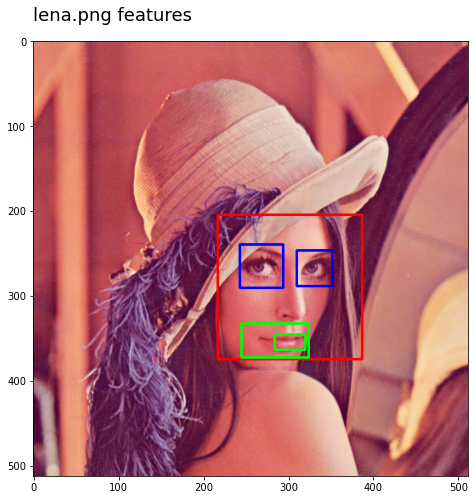

Couldn't detect face(s), reducing minNeighbors = 1
Found 1 face(s).
Couldn't detect eye(s), reducing minNeighbors = 1
No eye detected.
Found 3 smile(s).
Couldn't detect hand(s), reducing minNeighbors = 1
Found 1 hand(s).


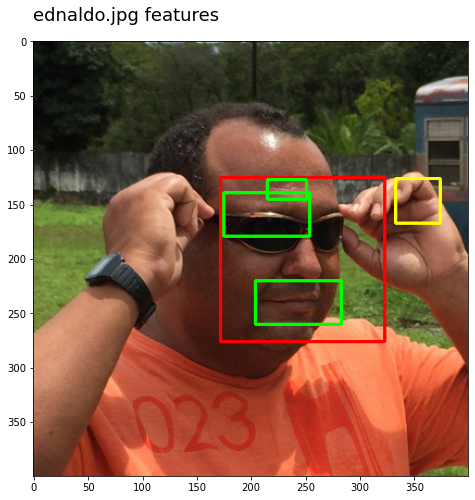

Found 3 face(s).
Couldn't detect eye(s), reducing minNeighbors = 1
No eye detected.
Couldn't detect smile(s), reducing minNeighbors = 1
Found 2 smile(s).
Couldn't detect eye(s), reducing minNeighbors = 1
Found 5 eye(s).
Found 2 smile(s).
Found 1 eye(s).
Couldn't detect smile(s), reducing minNeighbors = 1
No smile detected.
Couldn't detect hand(s), reducing minNeighbors = 1
No hand detected.


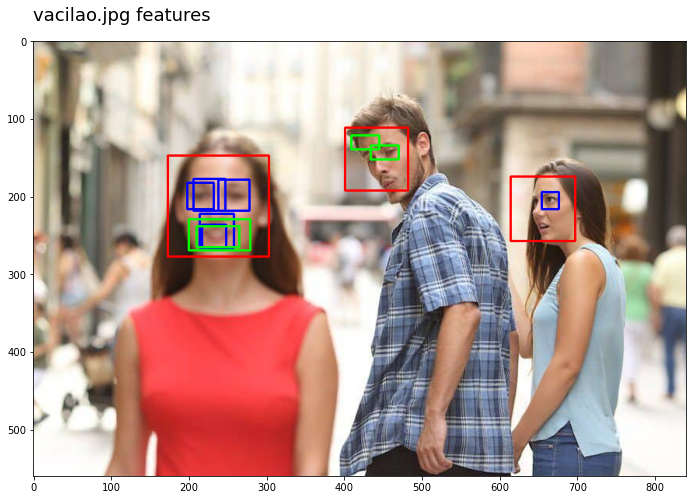

Couldn't detect face(s), reducing minNeighbors = 1
No face detected.
Couldn't detect hand(s), reducing minNeighbors = 1
No hand detected.


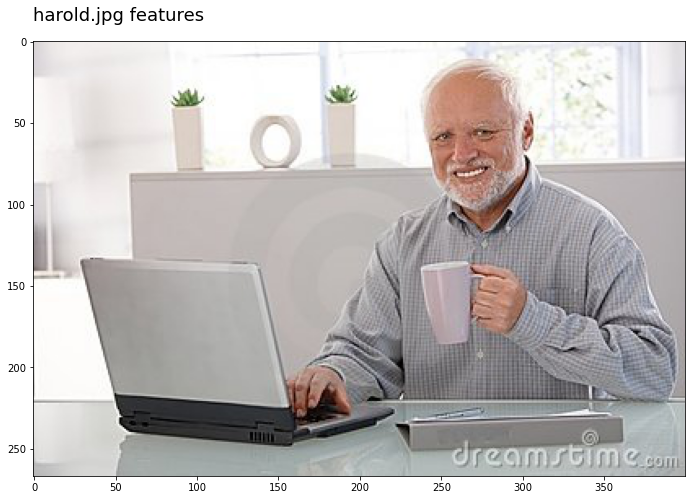

Found 3 face(s).
Couldn't detect eye(s), reducing minNeighbors = 1
No eye detected.
Found 2 smile(s).
Couldn't detect eye(s), reducing minNeighbors = 1
No eye detected.
Couldn't detect smile(s), reducing minNeighbors = 1
Found 1 smile(s).
Couldn't detect eye(s), reducing minNeighbors = 1
No eye detected.
Found 1 smile(s).
Couldn't detect hand(s), reducing minNeighbors = 1
No hand detected.


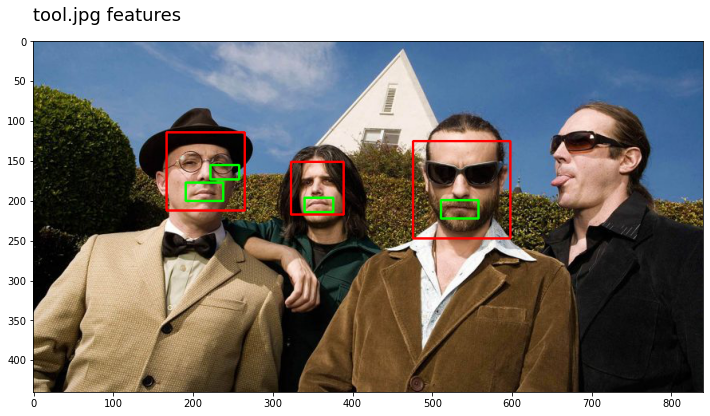

In [14]:
for name, image in images.items():
    search_for_features(image, name, reduce_penalty=True)

## Features search in live video

In [25]:
video = cv2.VideoCapture(0)

# Begin loop
while True:
    
    # keep webcam connected
    _, frame = video.read()
    
    # set panlties for each clasifier
    feature_penalty = {
        'face'         : 5,
        'eye'          : 8,
        'smile'        : 10,
        'hand'         : 3,
        'profile_face' : 5
    }
    
    # feature scan
    features_scan(frame, feature_penalty, verbose=False)
    
    # show video
    cv2.imshow('Video',frame)
    
    # close video window
    if cv2.waitKey(1) == ord('s'):
        break
        
# Release video capture
video.release()
# Memory dump
cv2.destroyAllWindows()
# fix window not closing bug on macOS 10.15
cv2.waitKey(1)

-1

## Alternative function for feature scan

### Feature detection functions v2

In [24]:
# Dected feature for a given classifier
def feature_detection_v2(rgb_image, gray_image, classifier, 
                      scaleFactor=1.3, minNeighbors=5, sub_search=False,
                      color=(255,0,0), c_name='', **kwargs):
    
    # Create empty tuples for roi
    roi_rgb, roi_gray = (), ()
    
    # Select region of interest
    classifier_results = classifier.detectMultiScale(gray_image, scaleFactor, minNeighbors)
        
    # Draw rectangle for current feature
    for (cx, cy, cw, ch) in classifier_results:
        
        # Apply drawing in image
        cv2.rectangle(img=rgb_image,       # image to draw
                      pt1=(cx, cy),        # top-left corner
                      pt2=(cx+cw, cy+ch),  # bottom-right corner
                      color=color,         # color of the rectangle (red)
                      thickness=2)         # thickness of the rectangle
        
        # Add identifier text
        cv2.putText(img=rgb_image,
                    text=c_name, 
                    org=(cx, cy), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=1,
                    color=(255,255,255),
                    thickness=1,
                    lineType=2)
    
        # Select the region of interest, both for gray and rgb scale
        if sub_search:
            roi_rgb  += ( rgb_image[cy:cy+ch, cx:cx+cw],)
            roi_gray += (gray_image[cy:cy+ch, cx:cx+cw],) 

    # Return roi values
    return roi_rgb, roi_gray

# Search for features given a dict of classifiers
def features_scan_v2(frame, classifiers):
    
    # Create gray scale image
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    for classifier in classifiers.values():
        # Detect features (global)
        if not classifier['is_sub']:
            c_roi_rgb, c_roi_gray = feature_detection_v2(frame, gray_frame, **classifier)
        # Detect sub_features
        if classifier['sub_search']:
            for roi_rgb, roi_gray in zip(c_roi_rgb, c_roi_gray):
                for sub_classifier in classifier['sub_class']:
                    feature_detection_v2(roi_rgb, roi_gray, **classifiers[sub_classifier])

def print_fps(video, frame, font=cv2.FONT_HERSHEY_SIMPLEX, color=(255, 255, 255)):
    
    # Get FPS
    fps = int(video.get(5))
    
    height, width, channel = frame.shape
    
    offset = int(height / len(text)) - 10

    cv2.putText(img=frame, 
                text=fps, 
                org=(50, offset), 
                font=font, 
                fontScale=1, 
                color=color, 
                thickness=5,
                lineType=8)

### Create dictionary of classifiers

In [26]:
classifiers = {
    'frontal_face':
    {
        'classifier'  : frontal_face_classifier,
        'minNeighbors': 5,
        'color'       : (255,0,0),
        'is_sub'      : False,
        'sub_search'  : True,
        'sub_class'   : ['eye', 'smile'],
        'c_name'        : 'Frontal face'
    },
    'profile_face':
    {
        'classifier'  : profile_face_classifier,
        'minNeighbors': 5,
        'color'       : (255,0,255),
        'is_sub'      : False,
        'sub_search'  : True,
        'sub_class'   : ['eye', 'smile'],
        'c_name'      : 'Profile face'
    },
    'hand':
    {
        'classifier'  : hand_classifier,
        'minNeighbors': 3,
        'color'       : (255,255,0),
        'is_sub'      : False,
        'sub_search'  : False,
        'sub_class'   : None,
        'c_name'      : 'Fist'
    },
    'eye':
    {
        'classifier'  : eye_classifier,
        'minNeighbors': 5,
        'color'       : (0,0,255),
        'is_sub'      : True,
        'sub_search'  : False,
        'sub_class'   : None,
        'c_name'      : 'Eye'
    },
    'smile':
    {
        'classifier'  : smile_classifier,
        'minNeighbors': 10,
        'color'       : (0,255,0),
        'is_sub'      : True,
        'sub_search'  : False,
        'sub_class'   : None,
        'c_name'      : 'Smile'
    },
}

### Test scan

In [27]:
video = cv2.VideoCapture(0)
video.set(cv2.CAP_PROP_FPS, 30)

print(fps)

# Begin loop
while True:
    # keep webcam connected
    _, frame = video.read()
    # feature scan
    features_scan_v2(frame, classifiers)
    # show video
    cv2.imshow('Video', frame)
    # print FPS
    cv2.putText(frame, 'FPS', (100, 120), font, 1, (255, 255, 255), 5, 2)
    #print_fps(frame, 'potato')
    # close video window
    if cv2.waitKey(1) == ord('s'):
        break

# Release video capture
video.release()
# Memory dump
cv2.destroyAllWindows()
# fix window not closing bug on macOS 10.15
cv2.waitKey(1)

29


-1